# Hist

## Setup

In [1]:
import hist
import boost_histogram as bh
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp

## Initialization

In [2]:
h = hist.Hist(
    hist.axis.Regular(50, -4, 4, name="S", title="s [units]", underflow=False, overflow=False),
    hist.axis.Regular(50, -4, 4, name="W", title="w [units]", underflow=False, overflow=False)
)

s_data = np.random.normal(size=1_000_000)
w_data = np.random.normal(size=1_000_000)

h.fill(s_data, w_data)

Hist(
  Regular(50, -4, 4, underflow=False, overflow=False, metadata={'name': 'S', 'title': 's [units]'}),
  Regular(50, -4, 4, underflow=False, overflow=False, metadata={'name': 'W', 'title': 'w [units]'}),
  storage=Double()) # Sum: 999882.0

## Matplotlib

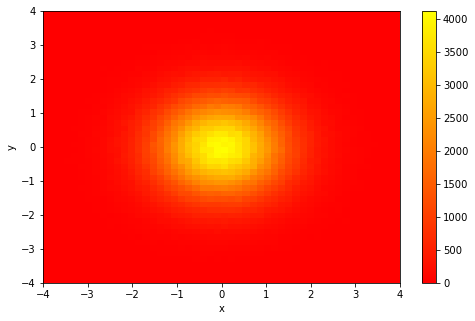

In [3]:
fig, ax = plt.subplots(figsize=(8,5))
w, x, y = h.to_numpy()
mesh = ax.pcolormesh(x, y, w.T, cmap='autumn')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(mesh)
plt.show()

## Plot

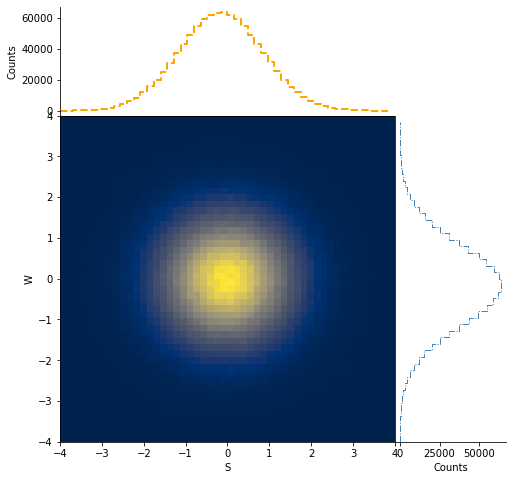

In [4]:
h.plot(main_cmap="cividis", top_ls="--", top_color="orange", top_lw=2, 
                         side_ls="-.", side_lw=1, side_color="steelblue")

plt.show()

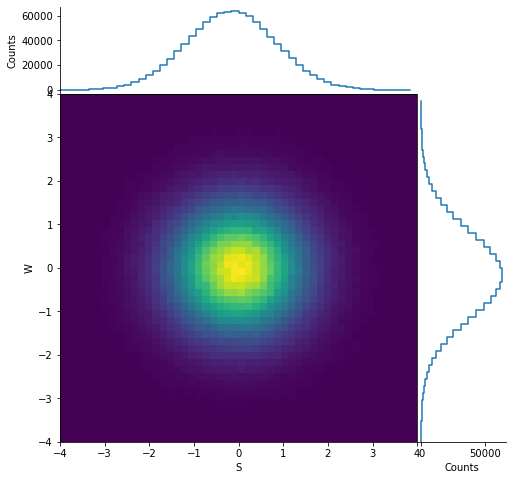

In [5]:
fig = plt.figure(figsize=(8, 8))
grid = fig.add_gridspec(5, 5, hspace=0, wspace=0)

main_ax = fig.add_subplot(grid[1:5, 0:4])
top_ax = fig.add_subplot(grid[0:1, 0:4], sharex=main_ax)
side_ax = fig.add_subplot(grid[1:5, 4:5], sharey=main_ax)

fig, main_ax, top_ax, side_ax = h.plot(fig, main_ax, top_ax, side_ax)
plt.show()

## Pull Plot

In [6]:
def pdf(x, a=1/np.sqrt(2*np.pi), x0=0, sigma=1, offset=0):
    exp = unp.exp if a.dtype == np.dtype("O") else np.exp
    return a * exp(-(x-x0)**2/(2*sigma**2)) + offset

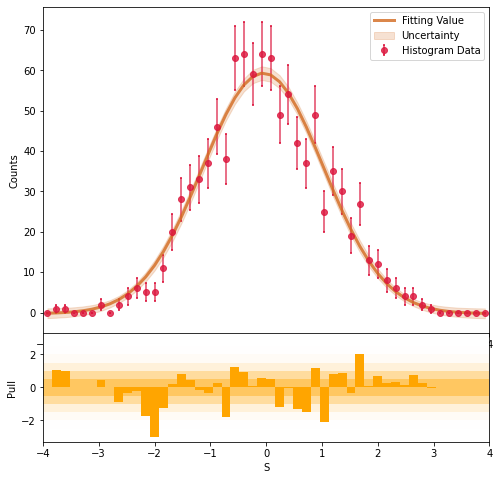

In [7]:
h = hist.Hist(
    hist.axis.Regular(50, -4, 4, name="S", title="s [units]", underflow=False, overflow=False)
)

data = np.random.normal(size=1_000)

h.fill(data)

h.plot_pull(pdf, eb_ecolor='crimson', eb_mfc='crimson', eb_mec='crimson', eb_fmt='o', eb_ms=6,\
                eb_capsize=1, eb_capthick=2, eb_alpha=.8, vp_c='orange', vp_ls='-', vp_lw=2,\
                vp_alpha=.8, fp_c='chocolate', fp_ls='-', fp_lw=3, fp_alpha=.8, bar_fc='orange',\
                pp_num=6, pp_fc='orange', pp_alpha=.618, pp_ec=None, ub_alpha=.2)

plt.show()

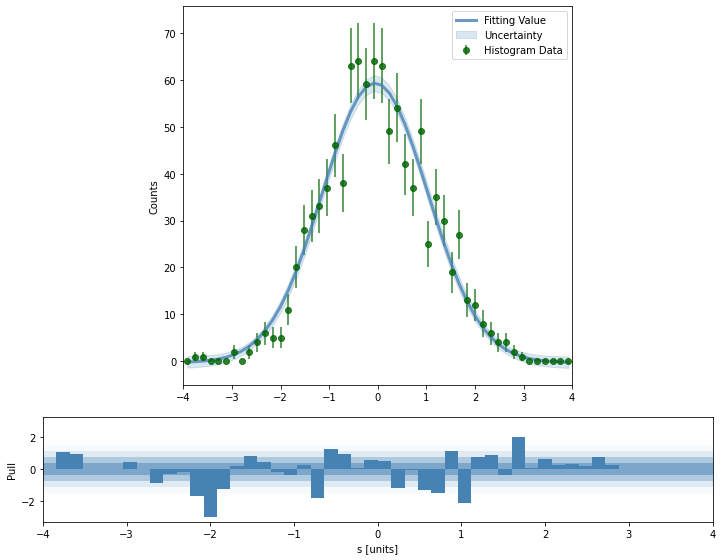

In [8]:
fig = plt.figure(figsize=(12, 12))
grid = fig.add_gridspec(5, 5, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(grid[0:3, 1:4])
pull_ax = fig.add_subplot(grid[3:4, :], sharex=ax)

fig, ax, pull_ax = h.plot_pull(pdf, fig=fig, ax=ax, pull_ax=pull_ax, eb_ecolor='darkgreen',\
                                eb_mfc='darkgreen', eb_mec='darkgreen', eb_fmt='o', eb_ms=6,\
                                eb_capsize=0, eb_alpha=.8, bar_fc='steelblue',\
                                pp_fc='steelblue', pp_num=8, pp_alpha=.7, fp_c='steelblue',\
                                fp_ls='-', fp_lw=3, fp_alpha=.8,ub_alpha=.2)

ax.set_ylabel("Counts")
pull_ax.set_xlabel(h.axes[0].title)
pull_ax.set_ylabel("Pull")
plt.show()

## MPLHEP

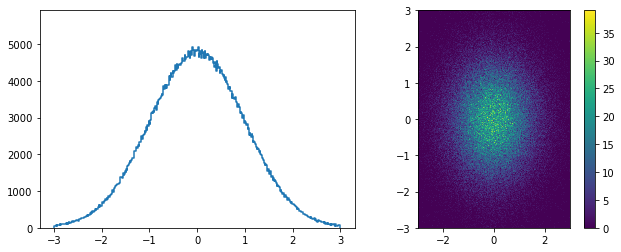

In [9]:
import mplhep

data_x = np.random.normal(loc=0., scale=1., size=1_000_000)
data_y = np.random.normal(loc=0., scale=1., size=1_000_000)

h_1d = hist.Hist(
    hist.axis.Regular(500, -3, 3, name='x_1d', underflow=False, overflow=False)
)

h_1d.fill(data_x)

h_2d = hist.Hist(
    hist.axis.Regular(500, -3, 3, name='x_2d', underflow=False, overflow=False),
    hist.axis.Regular(500, -3, 3, name='y_2d', underflow=False, overflow=False)
)

h_2d.fill(data_x, data_y)

plt.subplot(121)
w, xbins = h_1d.to_numpy()
mplhep.histplot(w.T, xbins)

plt.subplot(122)
w, xbins, ybins = h_2d.to_numpy()
mplhep.hist2dplot(w.T, xbins, ybins)

plt.show()